In [1]:
from espuma import Case_Directory, Boundary_Probe
from espuma.base import Field_File
from math import pi, sqrt
from shutil import rmtree

import pyvista as pv
import matplotlib.pyplot as plt

pv.start_xvfb()
pv.set_jupyter_backend("static")

In [2]:
def show_mesh(of: Case_Directory):
    reader = of.get_vtk_reader()
    reader.set_active_time_point(0)
 
    mesh = reader.read()
    internalMesh = mesh["internalMesh"]

    plotter = pv.Plotter()
    plotter.window_size = [300,400]
    plotter.add_mesh(internalMesh, color="pink", show_edges=True)
    plotter.show()

In [3]:
of_template = Case_Directory("template")
rmtree("case_name")
of_case = Case_Directory.clone_from_template(of_template, "case_name", overwrite=True)

foamCloneCase /home/edsaac/Repos/cowerc-adsorption/notebooks/calibration/template case_name finished successfully!


In [4]:
input_concentrations = {
    "pfoa": 1425e-6,
    "pfba": 1031.6e-6,
    "dcf": 0,
    "bez": 0,
    "pfhxs": 0,
    "genx": 0,
    "pfhxa": 0,
    "OM": 70e-3
}

## Assign concentrations
for k,v in input_concentrations.items():
    getattr(of_case.zero, f"{k}_aq")['boundaryField.top.uniformInletValue'] = f"constant {v}"

# ## Print to check
# for k,v in of_case.zero.__dict__.items():
#     if isinstance(v, Field_File) and k.endswith("_aq"):
#         print(k, "-->", getattr(of_case.zero, k)['boundaryField.top.uniformInletValue'])


In [5]:
porosity = 0.5
column_side_length = float(of_case.system.blockMeshDict["diameter"])
column_length = float(of_case.system.blockMeshDict["length"])
cross_area = column_side_length**2
column_pore_volume = porosity * column_length * cross_area

flow_rate = 6.26 / (1000*1000*60) #mL/min -> m³/s
darcy_rate = flow_rate / cross_area  #m/s
time_pore_volume = column_pore_volume / flow_rate

print(f"{time_pore_volume = :.3f} s")

of_case.zero.darcyFlux['internalField'] = f"uniform (0 0 {-darcy_rate:.3e});"

time_pore_volume = 0.908 s


In [6]:
# Delta_t from CFL = 1
pore_vel = darcy_rate / porosity  # m/s
delta_x = float(of_case.system.blockMeshDict["deltaLength"])  # m
cfl = 0.95

print(f"{(delta_t := cfl * delta_x / pore_vel) = }")
of_case.system.controlDict["deltaT"] = round(delta_t, 3)

# print(f'{of_case.system.controlDict["deltaT"] = }')
# print(f'{of_case.zero.darcyFlux["internalField"] = }')

(delta_t := cfl * delta_x / pore_vel) = 0.03783077637009585


In [7]:
# End time after an hour, write every minute
of_case.system.controlDict["endTime"] = 60
of_case.system.controlDict["writeInterval"] = 1
of_case.system.boundaryProbes["writeInterval"] = 0.05

In [8]:
of_case._blockMesh()
# show_mesh(of_case)

blockMesh finished successfully!


In [9]:
of_case._runCase()

organicMatterFoam finished successfully!


In [10]:
prb = Boundary_Probe(of_case, of_case.system.boundaryProbes)
prb_data = prb.array_data

In [13]:
prb_data

<xarray.Dataset>
Dimensions:   (probes: 2, time: 600)
Coordinates:
  * probes    (probes) object Point(x=0.0, y=0.0, z=0.0) Point(x=0.0, y=0.0, ...
  * time      (time) float64 0.114 0.19 0.304 0.418 ... 59.7 59.81 59.89 60.0
Data variables:
    OM_aq     (probes, time) float64 6.152e-16 7.379e-11 8.803e-09 ... 0.07 0.07
    bez_aq    (probes, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dcf_aq    (probes, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    genx_aq   (probes, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pfba_aq   (probes, time) float64 8.608e-18 9.626e-13 ... 0.001032 0.001032
    pfhxa_aq  (probes, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pfhxs_aq  (probes, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pfoa_aq   (probes, time) float64 1.126e-17 1.171e-12 ... 0.001425 0.001425

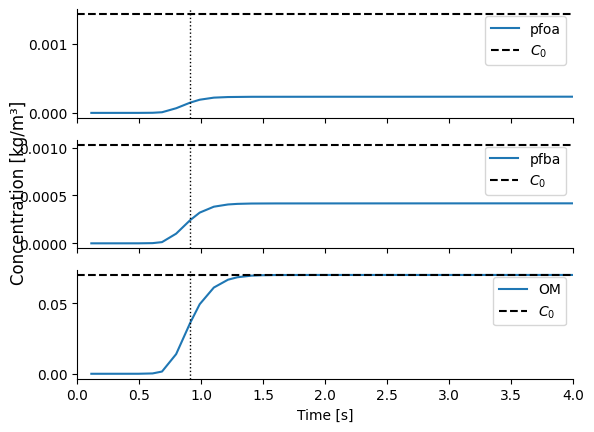

In [11]:
contaminants = ["pfoa_aq", "pfba_aq", "OM_aq"]
time = prb_data.time

fig,axs = plt.subplots(len(contaminants), 1, sharex=True)

for cont,ax in zip(contaminants, axs):
    cont_name = cont.partition("_")[0]
    ax.plot(time, prb_data[cont].isel(probes=0), label=cont_name)
    ax.axhline(input_concentrations[cont_name], ls='dashed', c='k', label="$C_0$")
    ax.legend()
    ax.axvline(time_pore_volume, ls='dotted', lw=1, c='k')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    # ax.set_ylim(bottom=0)

fig.supylabel("Concentration [kg/m³]")
ax.set_xlim(left=0, right=4)
ax.set_xlabel("Time [s]")
plt.show()



In [12]:
of_case.constant.transportProperties["retention_capacity"]

'retention_capacity [ 1 -3 0 0 0 0 0 ] 1'